### 1. Data Preprocessing

Tensorflow and Pandas are imported for data preprocessing and analysis

In [1]:
import tensorflow as tf
import pandas as pd
import shutil

train_set = pd.read_csv('./data/train.csv')
test_set = pd.read_csv('./data/test.csv')
description = train_set.describe(include = 'all')
corr = train_set.corr()

sns class is imported to check correlations between numerical values in data.

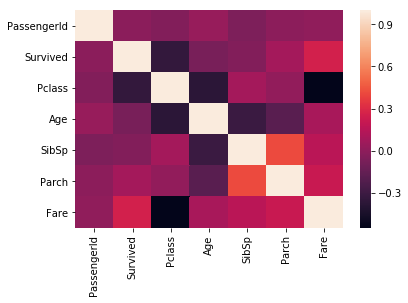

In [2]:
import seaborn as sns
%matplotlib inline
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns
    )

Since the correlation matrix shows that there is no strong correlation between each variables, no crossed_columns will be made.

In [3]:
print(description)

        PassengerId    Survived      Pclass  \
count    891.000000  891.000000  891.000000   
unique          NaN         NaN         NaN   
top             NaN         NaN         NaN   
freq            NaN         NaN         NaN   
mean     446.000000    0.383838    2.308642   
std      257.353842    0.486592    0.836071   
min        1.000000    0.000000    1.000000   
25%      223.500000    0.000000    2.000000   
50%      446.000000    0.000000    3.000000   
75%      668.500000    1.000000    3.000000   
max      891.000000    1.000000    3.000000   

                                     Name   Sex         Age       SibSp  \
count                                 891   891  714.000000  891.000000   
unique                                891     2         NaN         NaN   
top     Kenyon, Mrs. Frederick R (Marion)  male         NaN         NaN   
freq                                    1   577         NaN         NaN   
mean                                  NaN   NaN   29.699118 

In [4]:
print(train_set.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

PassengerId, Name, and Ticket will be removed since both PassengerId and name is irrelevant features and Ticket number is irrelevant as well.

sklearn's train_test_split method is used to split train data into training set and validation set. Missing values in Embarked is filled with 'S' because it's the most frequent category and Cabin's missing values are filled with N to stand for nan, since majority of them are missing values. The rest of the numerical data is filled with 0.

In [5]:
from sklearn.model_selection import train_test_split
train_set['Embarked'] = train_set['Embarked'].fillna('S')
train_set['Cabin'] = train_set['Cabin'].fillna('N')
train_set['Cabin'] = train_set['Cabin'].apply(lambda x: x[0])
train_set = train_set.fillna(0)

#select featuers and labels
features = train_set[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Cabin']]
labels = train_set.pop('Survived')
#split data
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.2)
#create input_fn and eval_fn functions for estimator tf class. Data are shuffled for performance.
train_input_fn = tf.estimator.inputs.pandas_input_fn(X_train,y_train,shuffle=True,num_epochs=10000)
eval_input_fn = tf.estimator.inputs.pandas_input_fn(X_test,y_test,shuffle=True)

### 2. Creating model
After preprocessing the data, feature columns are constructed for estimator class in tensorflow.

In [6]:
#pClass is a cateogrical variable and values between 1~3 so categorical_column_with_identity is used
pClass_column = tf.feature_column.categorical_column_with_identity('Pclass',4)
pClass_column = tf.feature_column.indicator_column(pClass_column)

#sex is another categorical variable with just male and female as categories
sex_column = tf.feature_column.categorical_column_with_vocabulary_list('Sex',['male','female'])
sex_column = tf.feature_column.indicator_column(sex_column)

#numerical columns are defined
age_column = tf.feature_column.numeric_column('Age')
sibSp_column = tf.feature_column.numeric_column('SibSp')
parch_column = tf.feature_column.numeric_column('Parch')
fare_column = tf.feature_column.numeric_column('Fare')

#embarked is another cateogrical variable with 3 different ports of entry
embarked_column = tf.feature_column.categorical_column_with_vocabulary_list('Embarked',['C','Q','S'])
embarked_column = tf.feature_column.indicator_column(embarked_column)

#cabin column is made but embedding of size 3 is used to reduce dimensions.
cabin_column = tf.feature_column.categorical_column_with_vocabulary_list('Cabin',['N','C','E','G','D','A','B','F','T'])
cabin_column = tf.feature_column.embedding_column(cabin_column,dimension=3)

run_config is created to save model and analyze training process on Tensorboard.

## Rationale for hyperparameters
Learning rate of 0.0002 was chosen after by-hand hyperparameter tuning.
Hidden units were heavily added to decrease loss.
Batch normalization was applied for faster learning.
Dropout was set to 0.45 for preventing overfitting and was chosen after by-hand hyperparmeter tuning.

In [7]:
run_config = tf.estimator.RunConfig(
        save_checkpoints_steps=500,
        save_summary_steps=500,
        model_dir="./model/",
        keep_checkpoint_max=None
)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0002)
estimator = tf.estimator.DNNClassifier(
        feature_columns=[age_column,pClass_column,sex_column,sibSp_column,fare_column,parch_column,embarked_column,cabin_column],
        hidden_units=[100,120,140,140,160,160,140,140,140,120,100],
        optimizer=optimizer,
        model_dir="./model/",
        dropout=0.45,
        batch_norm=True,
        config=run_config
)
train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn,max_steps=50000)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn,throttle_secs=20,start_delay_secs=20)
shutil.rmtree("./model/",ignore_errors=True)

INFO:tensorflow:Using config: {'_model_dir': './model/', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C0D69F6160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
#running training
tf.estimator.train_and_evaluate(estimator,train_spec,eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 500 or save_checkpoints_secs None.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:loss = 105.67605, step = 0
INFO:tensorflow:global_step/sec: 28.3161
INFO:tensorflow:loss = 95.51211, step = 100 (3.532 sec)
INFO:tensorflow:global_step/sec: 69.5335
INFO:tensorflow:loss = 101.33946, step = 200 (1.438 sec)
INFO:tensorflow:global_step/sec: 70.4619
INFO:tensorflow:loss = 105.54

INFO:tensorflow:loss = 79.28744, step = 3300 (1.499 sec)
INFO:tensorflow:global_step/sec: 68.6761
INFO:tensorflow:loss = 83.6801, step = 3400 (1.455 sec)
INFO:tensorflow:Saving checkpoints for 3500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-3500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (20 secs).
INFO:tensorflow:global_step/sec: 50.0336
INFO:tensorflow:loss = 85.49063, step = 3500 (2.000 sec)
INFO:tensorflow:global_step/sec: 66.5339
INFO:tensorflow:loss = 85.2474, step = 3600 (1.503 sec)
INFO:tensorflow:global_step/sec: 68.2095
INFO:tensorflow:loss = 86.81933, step = 3700 (1.465 sec)
INFO:tensorflow:global_step/sec: 68.6762
INFO:tensorflow:loss = 85.0029, step = 3800 (1.456 sec)
INFO:tensorflow:global_step/sec: 68.3952
INFO:tensorflow:loss = 85.90961, step = 3900 (1.463 sec)
INFO:tensorflow:Saving checkpoints for 4000 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-4000 i

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7000: ./model/model.ckpt-7000
INFO:tensorflow:global_step/sec: 20.4585
INFO:tensorflow:loss = 61.54453, step = 7000 (4.889 sec)
INFO:tensorflow:global_step/sec: 57.2628
INFO:tensorflow:loss = 65.39791, step = 7100 (1.745 sec)
INFO:tensorflow:global_step/sec: 57.4269
INFO:tensorflow:loss = 54.227085, step = 7200 (1.740 sec)
INFO:tensorflow:global_step/sec: 58.9807
INFO:tensorflow:loss = 57.115555, step = 7300 (1.695 sec)
INFO:tensorflow:global_step/sec: 61.1386
INFO:tensorflow:loss = 63.019585, step = 7400 (1.636 sec)
INFO:tensorflow:Saving checkpoints for 7500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-7500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (20 secs).
INFO:tensorflow:global_step/sec: 43.4622
INFO:tensorflow:loss = 69.912315, step = 7500 (2.302 sec)
INFO:tensorflow:global_step/sec: 65.4913
INFO:tensorflow:loss = 7

INFO:tensorflow:global_step/sec: 55.2437
INFO:tensorflow:loss = 52.62114, step = 10600 (1.809 sec)
INFO:tensorflow:global_step/sec: 56.425
INFO:tensorflow:loss = 59.050484, step = 10700 (1.771 sec)
INFO:tensorflow:global_step/sec: 60.2568
INFO:tensorflow:loss = 49.057377, step = 10800 (1.661 sec)
INFO:tensorflow:global_step/sec: 61.3256
INFO:tensorflow:loss = 52.131493, step = 10900 (1.630 sec)
INFO:tensorflow:Saving checkpoints for 11000 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-11000 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-05-04:25:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-11000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-05-04:25:18
INFO:tensorflow:Saving dict for global step 11000: accu

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-05-04:26:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-05-04:26:20
INFO:tensorflow:Saving dict for global step 14000: accuracy = 0.7094972, accuracy_baseline = 0.63128495, auc = 0.8498927, auc_precision_recall = 0.8411589, average_loss = 0.5736676, global_step = 14000, label/mean = 0.36871508, loss = 51.343246, precision = 0.9375, prediction/mean = 0.21238214, recall = 0.22727273
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 14000: ./model/model.ckpt-14000
INFO:tensorflow:global_step/sec: 21.9547
INFO:tensorflow:loss = 54.132545, step = 14000 (4.555 sec)
INFO:tensorflow:global_step/sec: 58.6358
INFO:tensorflow:loss = 47.942, step = 14100 (1.705 sec)
INFO:tensorflow:global_step/sec: 64.1921
INFO:

INFO:tensorflow:global_step/sec: 58.0255
INFO:tensorflow:loss = 59.613724, step = 17100 (1.720 sec)
INFO:tensorflow:global_step/sec: 61.8552
INFO:tensorflow:loss = 48.47644, step = 17200 (1.617 sec)
INFO:tensorflow:global_step/sec: 56.8086
INFO:tensorflow:loss = 48.003372, step = 17300 (1.760 sec)
INFO:tensorflow:global_step/sec: 56.0779
INFO:tensorflow:loss = 46.76486, step = 17400 (1.784 sec)
INFO:tensorflow:Saving checkpoints for 17500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-17500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (20 secs).
INFO:tensorflow:global_step/sec: 43.3676
INFO:tensorflow:loss = 51.109985, step = 17500 (2.306 sec)
INFO:tensorflow:global_step/sec: 53.3914
INFO:tensorflow:loss = 49.430973, step = 17600 (1.872 sec)
INFO:tensorflow:global_step/sec: 60.293
INFO:tensorflow:loss = 37.85978, step = 17700 (1.659 sec)
INFO:tensorflow:global_step/sec: 64.7303
INFO:tensorfl

INFO:tensorflow:global_step/sec: 63.4603
INFO:tensorflow:loss = 46.598446, step = 20700 (1.575 sec)
INFO:tensorflow:global_step/sec: 63.0611
INFO:tensorflow:loss = 38.87899, step = 20800 (1.588 sec)
INFO:tensorflow:global_step/sec: 59.5765
INFO:tensorflow:loss = 52.830856, step = 20900 (1.677 sec)
INFO:tensorflow:Saving checkpoints for 21000 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-05-04:28:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-21000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-05-04:28:46
INFO:tensorflow:Saving dict for global step 21000: accuracy = 0.72625697, accuracy_baseline = 0.63128495, auc = 0.86115575, auc_precision_recall = 0.85676

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-24000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-05-04:29:49
INFO:tensorflow:Saving dict for global step 24000: accuracy = 0.76536316, accuracy_baseline = 0.63128495, auc = 0.86035126, auc_precision_recall = 0.86644983, average_loss = 0.48396987, global_step = 24000, label/mean = 0.36871508, loss = 43.315304, precision = 0.96153843, prediction/mean = 0.24033271, recall = 0.37878788
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: ./model/model.ckpt-24000
INFO:tensorflow:global_step/sec: 21.9258
INFO:tensorflow:loss = 44.389244, step = 24000 (4.562 sec)
INFO:tensorflow:global_step/sec: 62.395
INFO:tensorflow:loss = 32.717663, step = 24100 (1.601 sec)
INFO:tensorflow:global_step/sec: 65.5342
INFO:tensorflow:loss = 44.214462, step = 24200 (1.526 sec)
INFO:tensorflow:global_step/sec: 6

INFO:tensorflow:global_step/sec: 56.7123
INFO:tensorflow:loss = 36.63504, step = 27200 (1.764 sec)
INFO:tensorflow:global_step/sec: 56.8408
INFO:tensorflow:loss = 44.976837, step = 27300 (1.758 sec)
INFO:tensorflow:global_step/sec: 64.1505
INFO:tensorflow:loss = 42.960518, step = 27400 (1.559 sec)
INFO:tensorflow:Saving checkpoints for 27500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-27500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (20 secs).
INFO:tensorflow:global_step/sec: 38.6238
INFO:tensorflow:loss = 30.54366, step = 27500 (2.590 sec)
INFO:tensorflow:global_step/sec: 56.2351
INFO:tensorflow:loss = 46.148674, step = 27600 (1.777 sec)
INFO:tensorflow:global_step/sec: 60.9898
INFO:tensorflow:loss = 40.66046, step = 27700 (1.640 sec)
INFO:tensorflow:global_step/sec: 55.9215
INFO:tensorflow:loss = 38.366177, step = 27800 (1.789 sec)
INFO:tensorflow:global_step/sec: 58.6702
INFO:tensorf

INFO:tensorflow:global_step/sec: 56.2351
INFO:tensorflow:loss = 32.247738, step = 30800 (1.777 sec)
INFO:tensorflow:global_step/sec: 58.8078
INFO:tensorflow:loss = 31.3344, step = 30900 (1.701 sec)
INFO:tensorflow:Saving checkpoints for 31000 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-31000 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-05-04:32:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-31000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-05-04:32:16
INFO:tensorflow:Saving dict for global step 31000: accuracy = 0.7877095, accuracy_baseline = 0.63128495, auc = 0.8776482, auc_precision_recall = 0.8650071, average_loss = 0.46015948, global_step = 31000, label/mean = 0.36871508, loss = 41.184273, precisio

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-05-04:33:20
INFO:tensorflow:Saving dict for global step 34000: accuracy = 0.79888266, accuracy_baseline = 0.63128495, auc = 0.85968083, auc_precision_recall = 0.85391784, average_loss = 0.45804617, global_step = 34000, label/mean = 0.36871508, loss = 40.995132, precision = 0.9166667, prediction/mean = 0.26484272, recall = 0.5
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 34000: ./model/model.ckpt-34000
INFO:tensorflow:global_step/sec: 20.972
INFO:tensorflow:loss = 28.897688, step = 34000 (4.769 sec)
INFO:tensorflow:global_step/sec: 53.4474
INFO:tensorflow:loss = 39.832687, step = 34100 (1.870 sec)
INFO:tensorflow:global_step/sec: 58.1934
INFO:tensorflow:loss = 29.24245, step = 34200 (1.719 sec)
INFO:tensorflow:global_step/sec: 58.7388
INFO:tensorflow:loss = 35.78675, step = 34300 (1.702 sec)
INFO:tensorflow:global_step/sec: 57.2956
INFO:te

INFO:tensorflow:global_step/sec: 61.8551
INFO:tensorflow:loss = 44.879715, step = 37300 (1.618 sec)
INFO:tensorflow:global_step/sec: 48.1823
INFO:tensorflow:loss = 42.44858, step = 37400 (2.074 sec)
INFO:tensorflow:Saving checkpoints for 37500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-37500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (20 secs).
INFO:tensorflow:global_step/sec: 43.7657
INFO:tensorflow:loss = 34.082924, step = 37500 (2.286 sec)
INFO:tensorflow:global_step/sec: 56.97
INFO:tensorflow:loss = 37.868927, step = 37600 (1.755 sec)
INFO:tensorflow:global_step/sec: 57.8911
INFO:tensorflow:loss = 41.711807, step = 37700 (1.727 sec)
INFO:tensorflow:global_step/sec: 55.9215
INFO:tensorflow:loss = 40.33899, step = 37800 (1.787 sec)
INFO:tensorflow:global_step/sec: 54.1693
INFO:tensorflow:loss = 48.576523, step = 37900 (1.847 sec)
INFO:tensorflow:Saving checkpoints for 38000 into ./mo

INFO:tensorflow:global_step/sec: 61.5514
INFO:tensorflow:loss = 42.22193, step = 40900 (1.626 sec)
INFO:tensorflow:Saving checkpoints for 41000 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-41000 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-05-04:35:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-41000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-05-04:35:48
INFO:tensorflow:Saving dict for global step 41000: accuracy = 0.7932961, accuracy_baseline = 0.63128495, auc = 0.86075354, auc_precision_recall = 0.8559567, average_loss = 0.45260203, global_step = 41000, label/mean = 0.36871508, loss = 40.50788, precision = 0.9142857, prediction/mean = 0.2741764, recall = 0.4848485
INFO:tensorflow:Saving 'checkpoint_p

INFO:tensorflow:Finished evaluation at 2018-09-05-04:36:51
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.79888266, accuracy_baseline = 0.63128495, auc = 0.8429874, auc_precision_recall = 0.85016227, average_loss = 0.46498764, global_step = 44000, label/mean = 0.36871508, loss = 41.616394, precision = 0.96875, prediction/mean = 0.25664163, recall = 0.46969697
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 44000: ./model/model.ckpt-44000
INFO:tensorflow:global_step/sec: 20.7078
INFO:tensorflow:loss = 35.619118, step = 44000 (4.830 sec)
INFO:tensorflow:global_step/sec: 54.7609
INFO:tensorflow:loss = 29.883629, step = 44100 (1.825 sec)
INFO:tensorflow:global_step/sec: 55.984
INFO:tensorflow:loss = 28.55272, step = 44200 (1.785 sec)
INFO:tensorflow:global_step/sec: 56.0465
INFO:tensorflow:loss = 31.67189, step = 44300 (1.784 sec)
INFO:tensorflow:global_step/sec: 58.295
INFO:tensorflow:loss = 41.023277, step = 44400 (1.716 sec)
INFO:tensorflow:Saving check

INFO:tensorflow:global_step/sec: 59.6829
INFO:tensorflow:loss = 44.30784, step = 47400 (1.677 sec)
INFO:tensorflow:Saving checkpoints for 47500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-47500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (20 secs).
INFO:tensorflow:global_step/sec: 44.3268
INFO:tensorflow:loss = 29.41134, step = 47500 (2.257 sec)
INFO:tensorflow:global_step/sec: 58.025
INFO:tensorflow:loss = 49.16061, step = 47600 (1.721 sec)
INFO:tensorflow:global_step/sec: 55.5805
INFO:tensorflow:loss = 33.88223, step = 47700 (1.800 sec)
INFO:tensorflow:global_step/sec: 57.7576
INFO:tensorflow:loss = 38.195625, step = 47800 (1.730 sec)
INFO:tensorflow:global_step/sec: 56.8409
INFO:tensorflow:loss = 37.480743, step = 47900 (1.760 sec)
INFO:tensorflow:Saving checkpoints for 48000 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-48000 is not in all_model_checkpoint_paths. Manual

({'accuracy': 0.81005585,
  'accuracy_baseline': 0.63128495,
  'auc': 0.8671896,
  'auc_precision_recall': 0.85713124,
  'average_loss': 0.43921763,
  'label/mean': 0.36871508,
  'loss': 39.30998,
  'precision': 0.92105263,
  'prediction/mean': 0.27878493,
  'recall': 0.530303,
  'global_step': 50000},
 [])

Final accuracy: 81%
Final loss: 39.3
Precision: 92.1%

#### Loss graph

![](https://github.com/RE-N-Y/ml-playground/raw/master/graphs/graph1.PNG)

#### Accuracy graph

![](https://github.com/RE-N-Y/ml-playground/raw/master/graphs/graph2.PNG)